In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader
import pickle
import itertools
import random

In [26]:
def distortion_analytical(x,encoder,decoder,r_all):
    #Logit r|x
    eta = encoder(x)
    bsize,N = eta.shape
    #ALERT: Gumbel Softmax trick
    p_r_x = torch.exp((eta@r_all) - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
    mu_dec,log_sigma = decoder(r_all.transpose(0,1)[:,None,:])
    sigma2_dec = torch.exp(2*log_sigma)
    inv_sigma2_dec = 1/sigma2_dec
    mp = mu_dec*inv_sigma2_dec
    logq_x_r = -0.5*(x**2)*inv_sigma2_dec + x*mp - 0.5*mu_dec*mp -\
    0.5*torch.log(2*np.pi*sigma2_dec)
    D = -((p_r_x*logq_x_r).sum(dim=1)).mean()
    return D


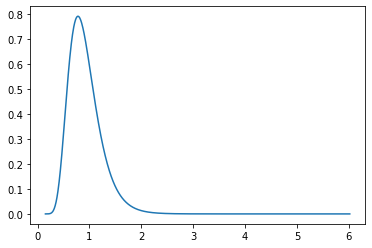

In [27]:
#Architecture parameters and distributions of stimuli
N = 10
K = 5
w = torch.distributions.Categorical(torch.ones(2,))
gs = torch.distributions.normal.Normal(torch.Tensor([-4,4]),torch.tensor([2,2]))
#p_x = torch.distributions.mixture_same_family.MixtureSameFamily(w,gs)
p_x = torch.distributions.log_normal.LogNormal(0,.5)
#Training parameters.
PRE_EPOCHS = 100
N_EPOCHS = 500
N_SAMPLES = 10000
lr = 1e-2
BATCH_SIZE = 100

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
plt.plot(x_fine,10**p_x.log_prob(x_fine).detach())

Text(0, 0.5, 'Encoding')

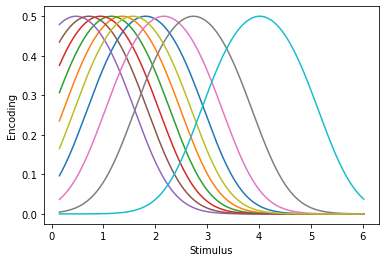

In [28]:
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted)
#enc.log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/(0.5*N))[None,:])
q = rate_ising(N)
#q = rate_vampBernoulli(K,x_fine)
x_k = x_fine[random.sample(range(1000),K)]
#q.x_k = torch.nn.Parameter(x_k)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder2n(N,100)
#enc.As = torch.nn.Parameter(torch.ones(N)[None,:])
#Plot initial state of encoder
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [14]:
#dec = GaussianDecoder()
#params = itertools.chain(enc.parameters(),q.parameters())
params = dec.parameters()
lr = 1e-3
opt = torch.optim.Adam(params,lr)

for e in range(PRE_EPOCHS):
    for x_ in x_data:
        distortion = distortion_analytical(x_,enc,dec,q.r_all)
        loss =  distortion 
        opt.zero_grad()
        loss.backward()
        opt.step()




KeyboardInterrupt: 

In [29]:
params =  list(enc.parameters()) +  list(dec.parameters())  + list(q.parameters())
lr = 1e-4
lVec,dVec,rVec = ([] for _ in range(3))
opt = torch.optim.Adam(params,lr)
beta = 0
for e in range(N_EPOCHS):
    lav = dav = rav = 0
    if beta <0:
        beta += 1/N_EPOCHS
    for x_ in x_data:
        rate = q(enc,x_)
        #print(rate)
        #distortion = distortion_gaussian(x_,enc,dec,lat_samp = 50,tau=0.01)
        distortion = distortion_analytical(x_,enc,dec,q.r_all)
        #print(enc.log_sigmas.grad)
        loss =  distortion + beta*rate
        opt.zero_grad()
        loss.backward()
        opt.step()
        lav += distortion + rate
        dav += distortion
        rav += rate
    #print(dav/len(x_data))
    lVec.append(lav.item()/len(x_data))
    rVec.append(rav.item()/len(x_data))
    dVec.append(dav.item()/len(x_data))

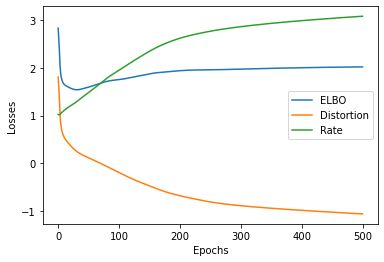

In [30]:
plt.plot(lVec,label='ELBO')
plt.plot(dVec,label='Distortion')
plt.plot(rVec,label='Rate')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

In [31]:
min(lVec),beta

(1.5417167663574218, 0)

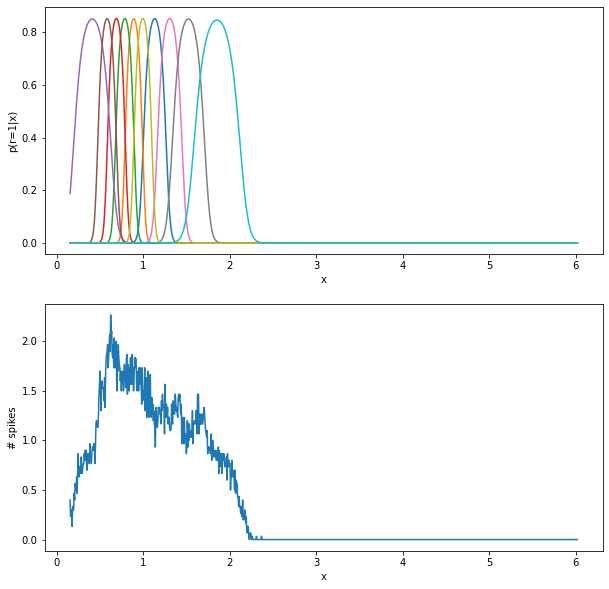

In [32]:
encoder_plots(enc,x_fine)

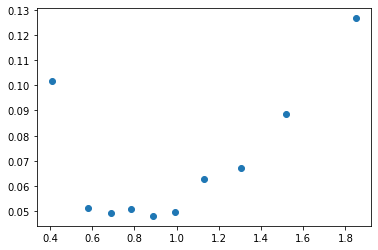

In [33]:
with torch.no_grad():
    plt.scatter(enc.cs,torch.exp(enc.log_sigmas))

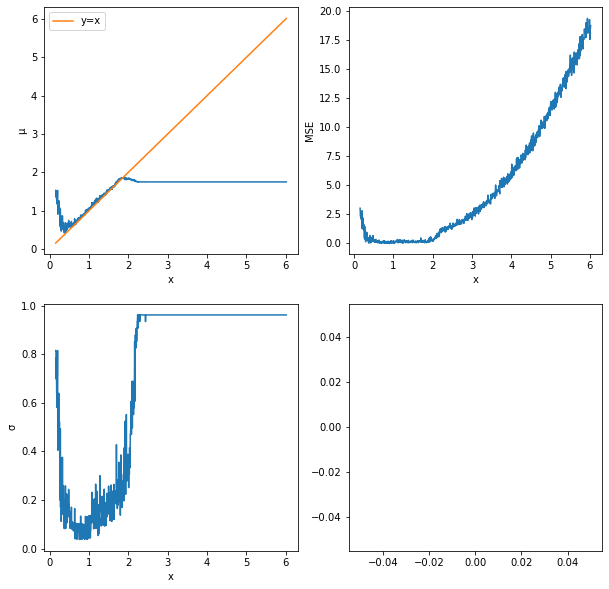

In [34]:
decoder_plots(enc,dec,x_fine)


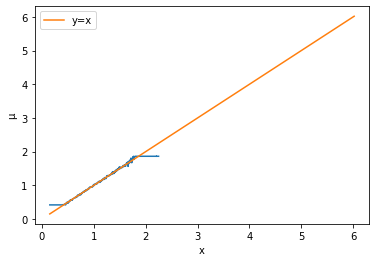

In [35]:
with torch.no_grad():
    r = enc.sample(x_fine,15)
    mu_dec,log_sigma_dec = dec(r)
    mu_dec = torch.where((r.sum(dim=2)) >0,mu_dec.double(),float('nan'))
    x_ext = dec.sample(r,10)
    mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
    fig,axs = plt.subplots()
    axs.plot(x_fine,mu_dec.nanmean(dim=1))
    axs.plot(x_fine,x_fine,label="y=x")
    axs.legend()
    axs.set_xlabel('x')
    axs.set_ylabel('μ')


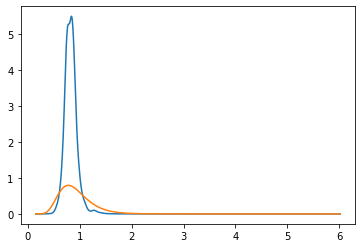

In [36]:
mu_dec,log_sigma = dec(q.r_all.transpose(0,1)[:,None,:])
q_r = torch.softmax(q.h@q.r_all + (q.r_all*(q.J@q.r_all)).sum(dim=0),1)
wq = torch.distributions.Categorical(q_r)
gsq = torch.distributions.normal.Normal(mu_dec,torch.exp(log_sigma))
q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
plt.plot(x_fine,10**q_x.log_prob(x_fine).detach())
plt.plot(x_fine,10**p_x.log_prob(x_fine).detach())

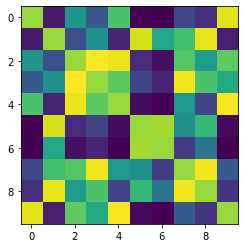

In [8]:
plt.imshow(q.J.detach())

In [16]:
torch.softmax()

TypeError: softmax() received an invalid combination of arguments - got (), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype)
 * (Tensor input, name dim, *, torch.dtype dtype)
